In [41]:
import sys
sys.path.append("../")

import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook
import engarde.decorators as ed
from library import analysis

from library import test
@ed.verify(test.allyearsandtpsd)
@ed.verify(test.alldois)
def load(data):
    return data


In [42]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/impact/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'cits_match.csv'),
                  sep=",", low_memory= False)
@ed.verify(test.allyearsandtpsd)
def load():
    return data
data = load()
data.head()

,Unnamed: 0,Unnamed: 0.1,district,distname,year,cntyname,distischarter,rating_academic,rating_financial,eligible,...,scores12,scores13,scores14,scores15,ps1,psweight1,pswtshare1,ps2,psweight2,pswtshare2
0,0,0,1902,CAYUGA ISD,2012,ANDERSON,N,NaN,NaN,NaN,...,0.376001,0.604081,0.624960,0.706106,0.891787,1.121344,0.109808,0.909282,1.099768,0.108109
1,1,1,1903,ELKHART ISD,2012,ANDERSON,N,NaN,NaN,NaN,...,-0.019918,0.120260,0.350077,0.523498,0.918142,1.089157,0.106656,0.919832,1.087155,0.106869
2,2,2,1904,FRANKSTON ISD,2012,ANDERSON,N,NaN,NaN,NaN,...,-0.127203,0.226864,0.293523,0.546765,0.870107,1.149283,0.112544,0.868654,1.151206,0.113165
3,3,3,1906,NECHES ISD,2012,ANDERSON,N,NaN,NaN,NaN,...,0.774340,0.887127,0.966082,0.242122,0.878874,1.137820,0.111421,0.929854,1.075438,0.105717
4,4,4,1907,PALESTINE ISD,2012,ANDERSON,N,NaN,NaN,NaN,...,-0.567740,-0.497350,-0.385973,-0.288506,0.843056,1.186161,0.116155,0.813548,1.229185,0.120831


# Select outcome

In [43]:
#outcome = 'avescores'
#outcome = 'math'
#outcome = 'reading'
outcome = 'science'
#outcome = 'elementary'
#outcome = 'middle'
#outcome = 'high'
#outcome = 'bio_std'


# Evidence of Parallel Trends

In [44]:
def create_group_df(df):
    new_df = pd.DataFrame(df.groupby(['year']).agg({outcome: ['mean', 'sem']}))
    new_df = new_df.rename(columns = {'mean': 'score_mean', 'sem': 'score_se'})
    new_df['ub'] = new_df[outcome]['score_mean'] + new_df[outcome]['score_se']
    new_df['lb'] = new_df[outcome]['score_mean'] - new_df[outcome]['score_se']
    return new_df
df_control = create_group_df(data[data.doi == False])
df_treat2016 = create_group_df(data[data.doi_year == 2016])
df_treat2017 = create_group_df(data[data.doi_year == 2017])
df_treat2018 = create_group_df(data[data.doi_year == 2018])
df_control

science                  ub        lb
     score_mean  score_se                    
year                                         
2012  -0.501890  0.053062 -0.448828 -0.554952
2013  -0.347212  0.053692 -0.293520 -0.400904
2014  -0.276177  0.058384 -0.217793 -0.334562
2015  -0.181821  0.056517 -0.125304 -0.238337
2016   0.134980  0.051516  0.186497  0.083464
2017   0.069142  0.061957  0.131100  0.007185
2018   0.321881  0.060241  0.382122  0.261640

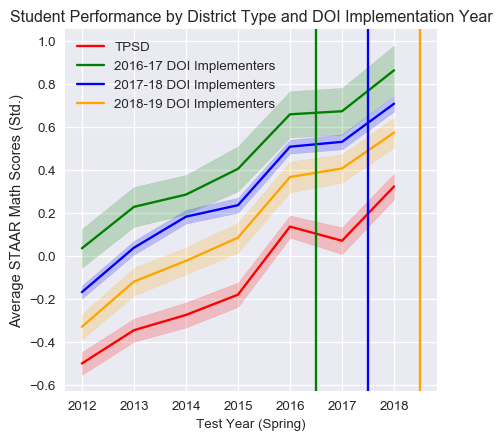

In [45]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control.index, df_control[outcome]['score_mean'], color = 'red', label = 'TPSD')
plt.plot(df_treat2016.index, df_treat2016[outcome]['score_mean'], color = 'green', label = '2016-17 DOI Implementers')
plt.plot(df_treat2017.index, df_treat2017[outcome]['score_mean'], color = 'blue', label = '2017-18 DOI Implementers')
plt.plot(df_treat2018.index, df_treat2018[outcome]['score_mean'], color = 'orange', label = '2018-19 DOI Implementers')

plt.legend()


plt.fill_between(df_control.index, df_control.lb, df_control.ub, color = 'red', alpha = .2)
plt.fill_between(df_treat2016.index, df_treat2016.lb, df_treat2016.ub, color = 'green', alpha = .2)
plt.fill_between(df_treat2017.index, df_treat2017.lb, df_treat2017.ub, color = 'blue', alpha = .2)
plt.fill_between(df_treat2018.index, df_treat2018.lb, df_treat2018.ub, color = 'orange', alpha = .2)

plt.axvline(x = 2016.5, color = 'green')
plt.axvline(x = 2017.5, color = 'blue')
plt.axvline(x = 2018.5, color = 'orange')



plt.ylabel('Average STAAR Math Scores (Std.)')
plt.title('Student Performance by District Type and DOI Implementation Year')
plt.xlabel('Test Year (Spring)', size = 'medium')


plt.savefig(table_path + 'math all districts and dates.png', dpi = 600, bbox_inches="tight")
plt.show()

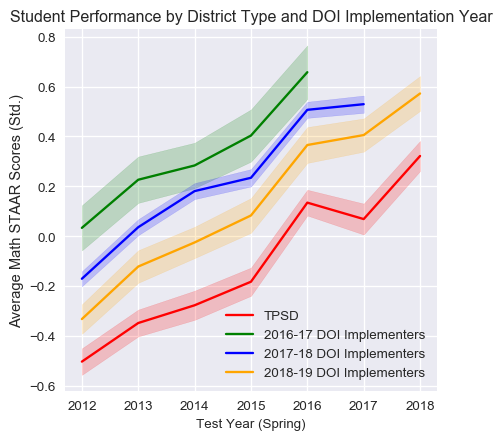

In [46]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control.index, df_control[outcome]['score_mean'], color = 'red', label = 'TPSD')
plt.plot(df_treat2016[df_treat2016.index <= 2016].index, df_treat2016[df_treat2016.index <= 2016][outcome]['score_mean'], color = 'green', label = '2016-17 DOI Implementers')
plt.plot(df_treat2017[df_treat2017.index <= 2017].index, df_treat2017[df_treat2017.index <= 2017][outcome]['score_mean'], color = 'blue', label = '2017-18 DOI Implementers')
plt.plot(df_treat2018[df_treat2018.index <= 2018].index, df_treat2018[df_treat2018.index <= 2018][outcome]['score_mean'], color = 'orange', label = '2018-19 DOI Implementers')

plt.legend()

plt.fill_between(df_control.index, df_control.lb, df_control.ub, color = 'red', alpha = .2)
plt.fill_between(df_treat2016[df_treat2016.index <= 2016].index, df_treat2016[df_treat2016.index <= 2016].lb, df_treat2016[df_treat2016.index <= 2016].ub, color = 'green', alpha = .2)
plt.fill_between(df_treat2017[df_treat2017.index <= 2017].index, df_treat2017[df_treat2017.index <= 2017].lb, df_treat2017[df_treat2017.index <= 2017].ub, color = 'blue', alpha = .2)
plt.fill_between(df_treat2018[df_treat2018.index <= 2018].index, df_treat2018[df_treat2018.index <= 2018].lb, df_treat2018[df_treat2018.index <= 2018].ub, color = 'orange', alpha = .2)


plt.ylabel('Average Math STAAR Scores (Std.)')
plt.title('Student Performance by District Type and DOI Implementation Year')
plt.xlabel('Test Year (Spring)', size = 'medium')

plt.savefig(table_path + 'math_parallel_trends_by_adoption.png', bbox_inches="tight")

plt.show()

# Fixed Effects

In [47]:
data_fe = pd.get_dummies(data = data, columns = ['year'])
reg_vars = ['year_centered', outcome, 'treat', 'psweight1', 'psweight2']
data_fe = data_fe.dropna(subset=reg_vars)
#data_fe = data_fe.dropna(reg_vars)
data_fe.head()

,Unnamed: 0,Unnamed: 0.1,district,distname,cntyname,distischarter,rating_academic,rating_financial,eligible,type,...,ps2,psweight2,pswtshare2,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,0,0,1902,CAYUGA ISD,ANDERSON,N,NaN,NaN,NaN,H,...,0.909282,1.099768,0.108109,1,0,0,0,0,0,0
1,1,1,1903,ELKHART ISD,ANDERSON,N,NaN,NaN,NaN,G,...,0.919832,1.087155,0.106869,1,0,0,0,0,0,0
2,2,2,1904,FRANKSTON ISD,ANDERSON,N,NaN,NaN,NaN,H,...,0.868654,1.151206,0.113165,1,0,0,0,0,0,0
3,3,3,1906,NECHES ISD,ANDERSON,N,NaN,NaN,NaN,H,...,0.929854,1.075438,0.105717,1,0,0,0,0,0,0
4,4,4,1907,PALESTINE ISD,ANDERSON,N,NaN,NaN,NaN,E,...,0.813548,1.229185,0.120831,1,0,0,0,0,0,0


In [48]:
formula = outcome + '~  + doi + treatpost +  year_2013 + year_2014 + year_2015 + year_2016 + year_2017 + year_2018'
y, X = dmatrices(formula,
                 data=data_fe, return_type='dataframe', NA_action = "drop")
cluster = data_fe.dropna(subset=reg_vars).district
mod = smf.OLS(y, X)    # Describe model
res = mod.fit(cov_type = 'cluster',  cov_kwds={'groups': pd.DataFrame(cluster)})       # Fit model
print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     252.8
Date:                Sat, 27 Apr 2019   Prob (F-statistic):          3.98e-231
Time:                        17:35:26   Log-Likelihood:                -7959.4
No. Observations:                6779   AIC:                         1.594e+04
Df Residuals:                    6770   BIC:                         1.600e+04
Df Model:                           8                                         
Covariance Type:              cluster                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5434      0.049    -11.025      

# CITS No Matching

In [49]:
reg_vars = [outcome, 'treat', 'year_centered', 'psweight2']
data_cits = data.dropna(subset=reg_vars)

In [50]:
formula = outcome + '~  treat + year_centered + treatyear + yearpost1 + treatpostyear1 + yearpost2 + treatpostyear2'
y, X = dmatrices(formula,
                 data=data_cits, return_type='dataframe', NA_action = "drop")
cluster = data_cits.district
mod = smf.OLS(y, X)    # Describe model
res = mod.fit(cov_type = 'cluster',  cov_kwds={'groups': pd.DataFrame(cluster)})       # Fit model
print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     177.7
Date:                Sat, 27 Apr 2019   Prob (F-statistic):          6.12e-169
Time:                        17:35:27   Log-Likelihood:                -7963.1
No. Observations:                6779   AIC:                         1.594e+04
Df Residuals:                    6771   BIC:                         1.600e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0573      0.052      1.

# Matching with Pretests

In [51]:
reg_vars = [outcome, 'treat', 'year_centered', 'psweight2']
data_ps = data.dropna(subset=reg_vars)

In [52]:
formula = outcome + '~ treat + year_centered + treatyear + yearpost1 + treatpostyear1 + yearpost2 + treatpostyear2'
y, X = dmatrices(formula,
                 data=data_ps, return_type='dataframe', NA_action = "drop")
cluster = data_ps.distname
psweights = data_ps.psweight2
mod = smf.WLS(y, X, weights = psweights)    # Describe model
res = mod.fit(cov_type = 'cluster',  cov_kwds={'groups': pd.DataFrame(cluster)})       # Fit model
print(res.summary())   # Summarize model

                            WLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.110
Model:                            WLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     149.5
Date:                Sat, 27 Apr 2019   Prob (F-statistic):          1.64e-149
Time:                        17:35:27   Log-Likelihood:                -8861.9
No. Observations:                6779   AIC:                         1.774e+04
Df Residuals:                    6771   BIC:                         1.779e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3313      0.060      5.